#### mod3_1 with regularization, C=0.0333; Score is 0.5228. Equal to best yet.

```
LogisticRegression(penalty='l2', dual=False, tol=0.0001, C=1.0, fit_intercept=True, intercept_scaling=1, 
                   class_weight=None, random_state=None, solver='liblinear', max_iter=100, multi_class='ovr', 
                   verbose=0, warm_start=False, n_jobs=1)
```

In [1]:
#### Imports/setup

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
pd.set_option('display.max_columns', 60)

from timeit import default_timer as timer

# for the pipeline
from sklearn.pipeline import Pipeline
# for the selectors
from sklearn.preprocessing import FunctionTransformer, StandardScaler, MaxAbsScaler
# for gluing preprocessed text and numbers together
from sklearn.pipeline import FeatureUnion
# for nans in the numeric data
from sklearn.preprocessing import Imputer

# Import classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier

# Import CountVectorizer
from sklearn.feature_extraction.text import CountVectorizer, HashingVectorizer

# metrics
from sklearn.metrics import f1_score, accuracy_score, classification_report

# unflattener
import python.flat_to_labels as ftl

#### Set up a train-test split making sure we have all labels in both splits
from python.multilabel import multilabel_train_test_split

from python.dd_mmll import multi_multi_log_loss, BOX_PLOTS_COLUMN_INDICES

#### Load the data

In [2]:
# Get data
the_data = pd.read_csv('data/TrainingData.csv', index_col=0)

# take a look
the_data.head()

,Function,Use,Sharing,Reporting,Student_Type,Position_Type,Object_Type,Pre_K,Operating_Status,Object_Description,Text_2,SubFund_Description,Job_Title_Description,Text_3,Text_4,Sub_Object_Description,Location_Description,FTE,Function_Description,Facility_or_Department,Position_Extra,Total,Program_Description,Fund_Description,Text_1
134338,Teacher Compensation,Instruction,School Reported,School,NO_LABEL,Teacher,NO_LABEL,NO_LABEL,PreK-12 Operating,NaN,NaN,NaN,Teacher-Elementary,NaN,NaN,NaN,NaN,1.0,NaN,NaN,KINDERGARTEN,50471.810,KINDERGARTEN,General Fund,NaN
206341,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,Non-Operating,CONTRACTOR SERVICES,BOND EXPENDITURES,BUILDING FUND,(blank),Regular,NaN,NaN,NaN,NaN,RGN GOB,NaN,UNDESIGNATED,3477.860,BUILDING IMPROVEMENT SERVICES,NaN,BUILDING IMPROVEMENT SERVICES
326408,Teacher Compensation,Instruction,School Reported,School,Unspecified,Teacher,Base Salary/Compensation,Non PreK,PreK-12 Operating,Personal Services - Teachers,NaN,NaN,TCHER 2ND GRADE,NaN,Regular Instruction,NaN,NaN,1.0,NaN,NaN,TEACHER,62237.130,Instruction - Regular,General Purpose School,NaN
364634,Substitute Compensation,Instruction,School Reported,School,Unspecified,Substitute,Benefits,NO_LABEL,PreK-12 Operating,EMPLOYEE BENEFITS,TEACHER SUBS,GENERAL FUND,"Teacher, Short Term Sub",Regular,NaN,NaN,NaN,NaN,UNALLOC BUDGETS/SCHOOLS,NaN,PROFESSIONAL-INSTRUCTIONAL,22.300,GENERAL MIDDLE/JUNIOR HIGH SCH,NaN,REGULAR INSTRUCTION
47683,Substitute Compensation,Instruction,School Reported,School,Unspecified,Teacher,Substitute Compensation,NO_LABEL,PreK-12 Operating,TEACHER COVERAGE FOR TEACHER,TEACHER SUBS,GENERAL FUND,"Teacher, Secondary (High)",Alternative,NaN,NaN,NaN,NaN,NON-PROJECT,NaN,PROFESSIONAL-INSTRUCTIONAL,54.166,GENERAL HIGH SCHOOL EDUCATION,NaN,REGULAR INSTRUCTION


####  Encode the targets as categorical variables

In [3]:
### bind variable LABELS - these are actually the targets and we're going to one-hot encode them...
LABELS = ['Function',  'Use',  'Sharing',  'Reporting',  'Student_Type',  'Position_Type', 
          'Object_Type',  'Pre_K',  'Operating_Status']

### This turns out to be key.  Submission requires the dummy versions of these vars to be in this order.
LABELS.sort()

# Define the lambda function: categorize_label
categorize_label = lambda x: x.astype('category')

# Convert df[LABELS] to a categorical type
the_data[LABELS] = the_data[LABELS].apply(categorize_label, axis=0)

# Print the converted dtypes
print(the_data[LABELS].dtypes)

Function            category
Object_Type         category
Operating_Status    category
Position_Type       category
Pre_K               category
Reporting           category
Sharing             category
Student_Type        category
Use                 category
dtype: object


#### Save the unique labels for each output (category)

In [4]:
# build a dictionary
the_labels = {col : the_data[col].unique().tolist() for col in the_data[LABELS].columns}
# take a look at one entry
the_labels['Use']

['Instruction',
 'NO_LABEL',
 'O&M',
 'Pupil Services & Enrichment',
 'ISPD',
 'Leadership',
 'Business Services',
 'Untracked Budget Set-Aside']

#### Change fraction to suit.
Note: small fractions will have a hard time ensuring labels in both splits.

In [5]:
# downsize it or not
# df = the_data.sample(frac=0.10, random_state=777) # this seed gets a split with enough labels in both sets
df = the_data.sample(frac=1.0, random_state=777)

#### Get targets as set of one-hot encoded columns

In [6]:
# name these columns
NUMERIC_COLUMNS = ['FTE', 'Total']

# Get labels and convert to dummy variables: label_dummies
label_dummies = pd.get_dummies(df[LABELS])

#### Setting up a train-test split  for modeling

In [7]:
# define combine_text_columns()
def combine_text_columns(df, to_drop=NUMERIC_COLUMNS + LABELS):
    """ converts all text columns in each row of df to single string """
    # Drop non-text columns that are in the df
    to_drop = set(to_drop) & set(df.columns.tolist())
    text_data = df.drop(to_drop, axis=1)  
    # Replace nans with blanks
    text_data.fillna('', inplace=True)    
    # Join all text items in a row that have a space in between
    return text_data.apply(lambda x: " ".join(x), axis=1)

In [8]:
# Import FunctionTransformer
from sklearn.preprocessing import FunctionTransformer

# Get the dummy encoding of the labels
dummy_labels = pd.get_dummies(df[LABELS])

# Get the features in the data
NON_LABELS = [c for c in df.columns if c not in LABELS]

# Split into training and test sets
X_train, X_test, y_train, y_test = multilabel_train_test_split(df[NON_LABELS],
                                                               dummy_labels,
                                                               0.2, 
                                                               seed=123)
# Preprocess the text data: get_text_data
get_text_data = FunctionTransformer(combine_text_columns, validate=False)

# Use all 0s instead of noise: get_numeric_data
get_numeric_data_hack = FunctionTransformer(lambda x: np.zeros(x[NUMERIC_COLUMNS].shape, dtype=np.float), validate=False)

#####  sb no scaler and C=0.03333 (third of a tenth)

In [9]:
#### Build the pipeline
mod_reg_033 = Pipeline([
        ('union', FeatureUnion(
            transformer_list = [
                ('numeric_features', get_numeric_data_hack),
                ('text_features', Pipeline([('selector', get_text_data),
                                            ('vectorizer', CountVectorizer(ngram_range=(1,2)))]))
             ])),
        # no scaler ('scale', MaxAbsScaler()),
        ('clf', OneVsRestClassifier(LogisticRegression(C=0.03333), n_jobs=-1))
    ])

start = timer()
# Fit to the training data
mod_reg_033.fit(X_train, y_train)
end = timer()
print('fit time: {:0.2f} seconds'.format(end - start))

# 384 sec all procs

fit time: 368.00 seconds


In [10]:
# get probas
start = timer()
mod_reg_033_train_probas = mod_reg_033.predict_proba(X_train)
mod_reg_033_test_probas = mod_reg_033.predict_proba(X_test)
end = timer()
print('Predict.proba time: {:0.2f} seconds'.format(end - start))

Predict.proba time: 24.53 seconds


In [11]:
print('log loss on training set: {:0.4f}'.format(multi_multi_log_loss(mod_reg_033_train_probas, 
                                                                      y_train.values, BOX_PLOTS_COLUMN_INDICES)))
print('log loss on test set: {:0.4f}'.format(multi_multi_log_loss(mod_reg_033_test_probas, 
                                                                      y_test.values, BOX_PLOTS_COLUMN_INDICES)))

# without scaling
# log loss on training set: 0.0743
# log loss on test set: 0.0808

log loss on training set: 0.1011
log loss on test set: 0.1059


In [12]:
def report_f1(true, pred):
    the_scores = []
    for target in range(len(LABELS)):
        the_score = f1_score(true[:, target], pred[:, target], average='weighted')
        print('F1 score for target {}: {:.3f}'.format(LABELS[target], the_score))
        the_scores.append(the_score)
    print('Average F1 score for all targets : {:.3f}'.format(np.mean(the_scores)))

def report_accuracy(true, pred):
    the_scores = []
    for target in range(len(LABELS)):
        the_score = accuracy_score(true[:, target], pred[:, target])
        print('Accuracy score for target {}: {:.3f}'.format(LABELS[target], the_score))
        the_scores.append(the_score)
    print('Average accuracy score for all targets : {:.3f}'.format(np.mean(the_scores)))

In [13]:
# ftl wants ndarray, not pd.Dataframe
the_ys = ftl.flat_to_labels(y_test.values)

In [14]:
report_f1(the_ys, ftl.flat_to_labels(mod_reg_033_test_probas))

report_accuracy(the_ys, ftl.flat_to_labels(mod_reg_033_test_probas))

F1 score for target Function: 0.950
F1 score for target Object_Type: 0.982
F1 score for target Operating_Status: 0.984
F1 score for target Position_Type: 0.979
F1 score for target Pre_K: 0.988
F1 score for target Reporting: 0.978
F1 score for target Sharing: 0.968
F1 score for target Student_Type: 0.974
F1 score for target Use: 0.963
Average F1 score for all targets : 0.974
Accuracy score for target Function: 0.951
Accuracy score for target Object_Type: 0.982
Accuracy score for target Operating_Status: 0.984
Accuracy score for target Position_Type: 0.980
Accuracy score for target Pre_K: 0.989
Accuracy score for target Reporting: 0.979
Accuracy score for target Sharing: 0.968
Accuracy score for target Student_Type: 0.974
Accuracy score for target Use: 0.964
Average accuracy score for all targets : 0.974


In [23]:
# LABELS = ['Function', 'Object_Type','Operating_Status', 'Position_Type', 'Pre_K', 
#           'Reporting','Sharing', 'Student_Type','Use']
# BPCI is the slices that get the columns associated with LABELS, i.e.
#          [slice(0, 37, None), slice(37, 48, None), slice(48, 51, None), slice(51, 76, None), slice(76, 79, None), 
#           slice(79, 82, None), slice(82, 87, None), slice(87, 96, None), slice(96, 104, None)]

# grab the columns for each target - that's in BPCI indexed by position in LABELS
# normalize so probabilities sum to one (unless sum is zero, then we clip)

BPCI=BOX_PLOTS_COLUMN_INDICES

def norm_probs(probs, indices=BPCI, targets = LABELS):
    ''' input:  array n_samples, 104 ; output: array n_samples, 104 
         normalized within target columns such that for each target, the sum of probabilities for each row is 1'''
    # make a copy; don't want to smash the input
    lprobs = np.copy(probs)
    for i, targ in enumerate(targets):
        lprobs[:, indices[i]] /=  np.clip(np.sum(lprobs[:, indices[i]], axis=1, keepdims=True), 1e-15, np.inf)
    return lprobs

from sklearn.metrics import log_loss
def report_log_loss(true, pred):
    ''' Takes true in binarized format.  Both args are shape (n_samples, 104)'''
    the_scores = []
    # note: BPCI[idx] is the slice that gets the right columns for each target
    # first normalize probabilities within targets 
    normed_probas = norm_probs(pred)
    the_scores = []
    for idx, target in enumerate(LABELS):
        the_score = log_loss(true[:, BPCI[idx]], pred[:, BPCI[idx]])
        print('log loss for target {}: {:.3f}'.format(target, the_score))
        the_scores.append(the_score)
    print('Average log_loss for all targets : {:.3f}'.format(np.mean(the_scores))) 

In [26]:
the_ys.shape, y_test.shape

((80055, 9), (80055, 104))

In [28]:
report_log_loss(y_test.values, mod_reg_033_test_probas)

log loss for target Function: 0.221
log loss for target Object_Type: 0.082
log loss for target Operating_Status: 0.054
log loss for target Position_Type: 0.107
log loss for target Pre_K: 0.039
log loss for target Reporting: 0.086
log loss for target Sharing: 0.126
log loss for target Student_Type: 0.094
log loss for target Use: 0.143
Average log_loss for all targets : 0.106


#### =========================== predict on holdout set ==================================

In [15]:
# # Load the holdout data: holdout
# ### Over here the file is TestData.csv
# holdout = pd.read_csv('data/TestData.csv', index_col=0)

In [16]:
# holdout.shape, the_data.shape

In [17]:
# start = timer()
# # Generate predictions: predictions
# mod_reg_033_predictions = mod_reg_033.predict_proba(holdout)
# end = timer()
# print('predict time: {} seconds'.format(end - start))

In [18]:
# pred_mod_reg_033 = pd.DataFrame(columns=pd.get_dummies(df[LABELS], prefix_sep='__').columns, 
#                              index=holdout.index,
#                              data=mod_reg_033_predictions)

# pred_mod_reg_033.to_csv('pred_mod_reg_033_new.csv')

####  =================== end mod_reg_033  ========================

#### Look at confusion matrix for Function (worst performing target)

In [29]:
from sklearn.metrics import confusion_matrix

In [31]:
the_ys[:, 0].shape, ftl.flat_to_labels(mod_reg_033_test_probas)[:, 0].shape

((80055,), (80055,))

In [33]:
np.set_printoptions(threshold=np.inf)

In [35]:
the_cm = confusion_matrix(the_ys[:, 0], ftl.flat_to_labels(mod_reg_033_test_probas)[:, 0])

In [ ]:
from pprint import pprint

In [42]:
def print_cm(cm, labels, hide_zeroes=False, hide_diagonal=False, hide_threshold=None):
    """pretty print for confusion matrixes"""
    columnwidth = max([len(x) for x in labels] + [5])  # 5 is value length
    empty_cell = " " * columnwidth
    # Print header
    print("    " + empty_cell, end=" ")
    for label in labels:
        print("%{0}s".format(columnwidth) % label, end=" ")
    print()
    # Print rows
    for i, label1 in enumerate(labels):
        print("    %{0}s".format(columnwidth) % label1, end=" ")
        for j in range(len(labels)):
            cell = "%{0}.1f".format(columnwidth) % cm[i, j]
            if hide_zeroes:
                cell = cell if float(cm[i, j]) != 0 else empty_cell
            if hide_diagonal:
                cell = cell if i != j else empty_cell
            if hide_threshold:
                cell = cell if cm[i, j] > hide_threshold else empty_cell
            print(cell, end=" ")
        print()

In [44]:
the_labels['Function']

['Teacher Compensation',
 'NO_LABEL',
 'Substitute Compensation',
 'Facilities & Maintenance',
 'Instructional Materials & Supplies',
 'Food Services',
 'Security & Safety',
 'Utilities',
 'Student Transportation',
 'Parent & Community Relations',
 'Extended Time & Tutoring',
 'Enrichment',
 'Special Population Program Management & Support',
 'School Supervision',
 'Data Processing & Information Services',
 'Aides Compensation',
 'Physical Health & Services',
 'Career & Academic Counseling',
 'Library & Media',
 'Professional Development',
 'School Administration',
 'Other Non-Compensation',
 'Social & Emotional',
 'Finance, Budget, Purchasing & Distribution',
 'Human Resources',
 'Curriculum Development',
 'Legal',
 'Other Compensation',
 'Student Assignment',
 'Governance',
 'Development & Fundraising',
 'Research & Accountability',
 'Recruitment',
 'Insurance',
 'Untracked Budget Set-Aside',
 'Communications',
 'Facilities Planning']

In [46]:
from python.plot_confusion_matrix import plot_confusion_matrix as plot_cm

Confusion matrix, without normalization
[[ 3957     0     0     2     1     0     2     2     2     0     0     1
      0     0     0     0     0     0     6     0     0     2     2     4
      0     0     6     0     1     2     3     0     0     4    13     0
      0]
 [    2   462     0     2     0     0     0     2     2     0     0     0
      0     0     2     0     0     0     2     0     0     0     1     3
      0     0     4     0     0    56     1     0     0     1    19     0
      0]
 [    0     0    44     0     0     0     0     0     3     0     0     0
      0     0     1     0     0     0    10     0     0     0     0     0
      0     0     2     0     0     0     2     0     0     0     1     0
      0]
 [   21     7     0  1337     2     0     4     2     8     0     2     0
      0     2    11     0     0     2    87     0     0     2     0    28
      0     0    12    14     1     0    21     0     0     5     7     0
      0]
 [    2     0     0     2   569     

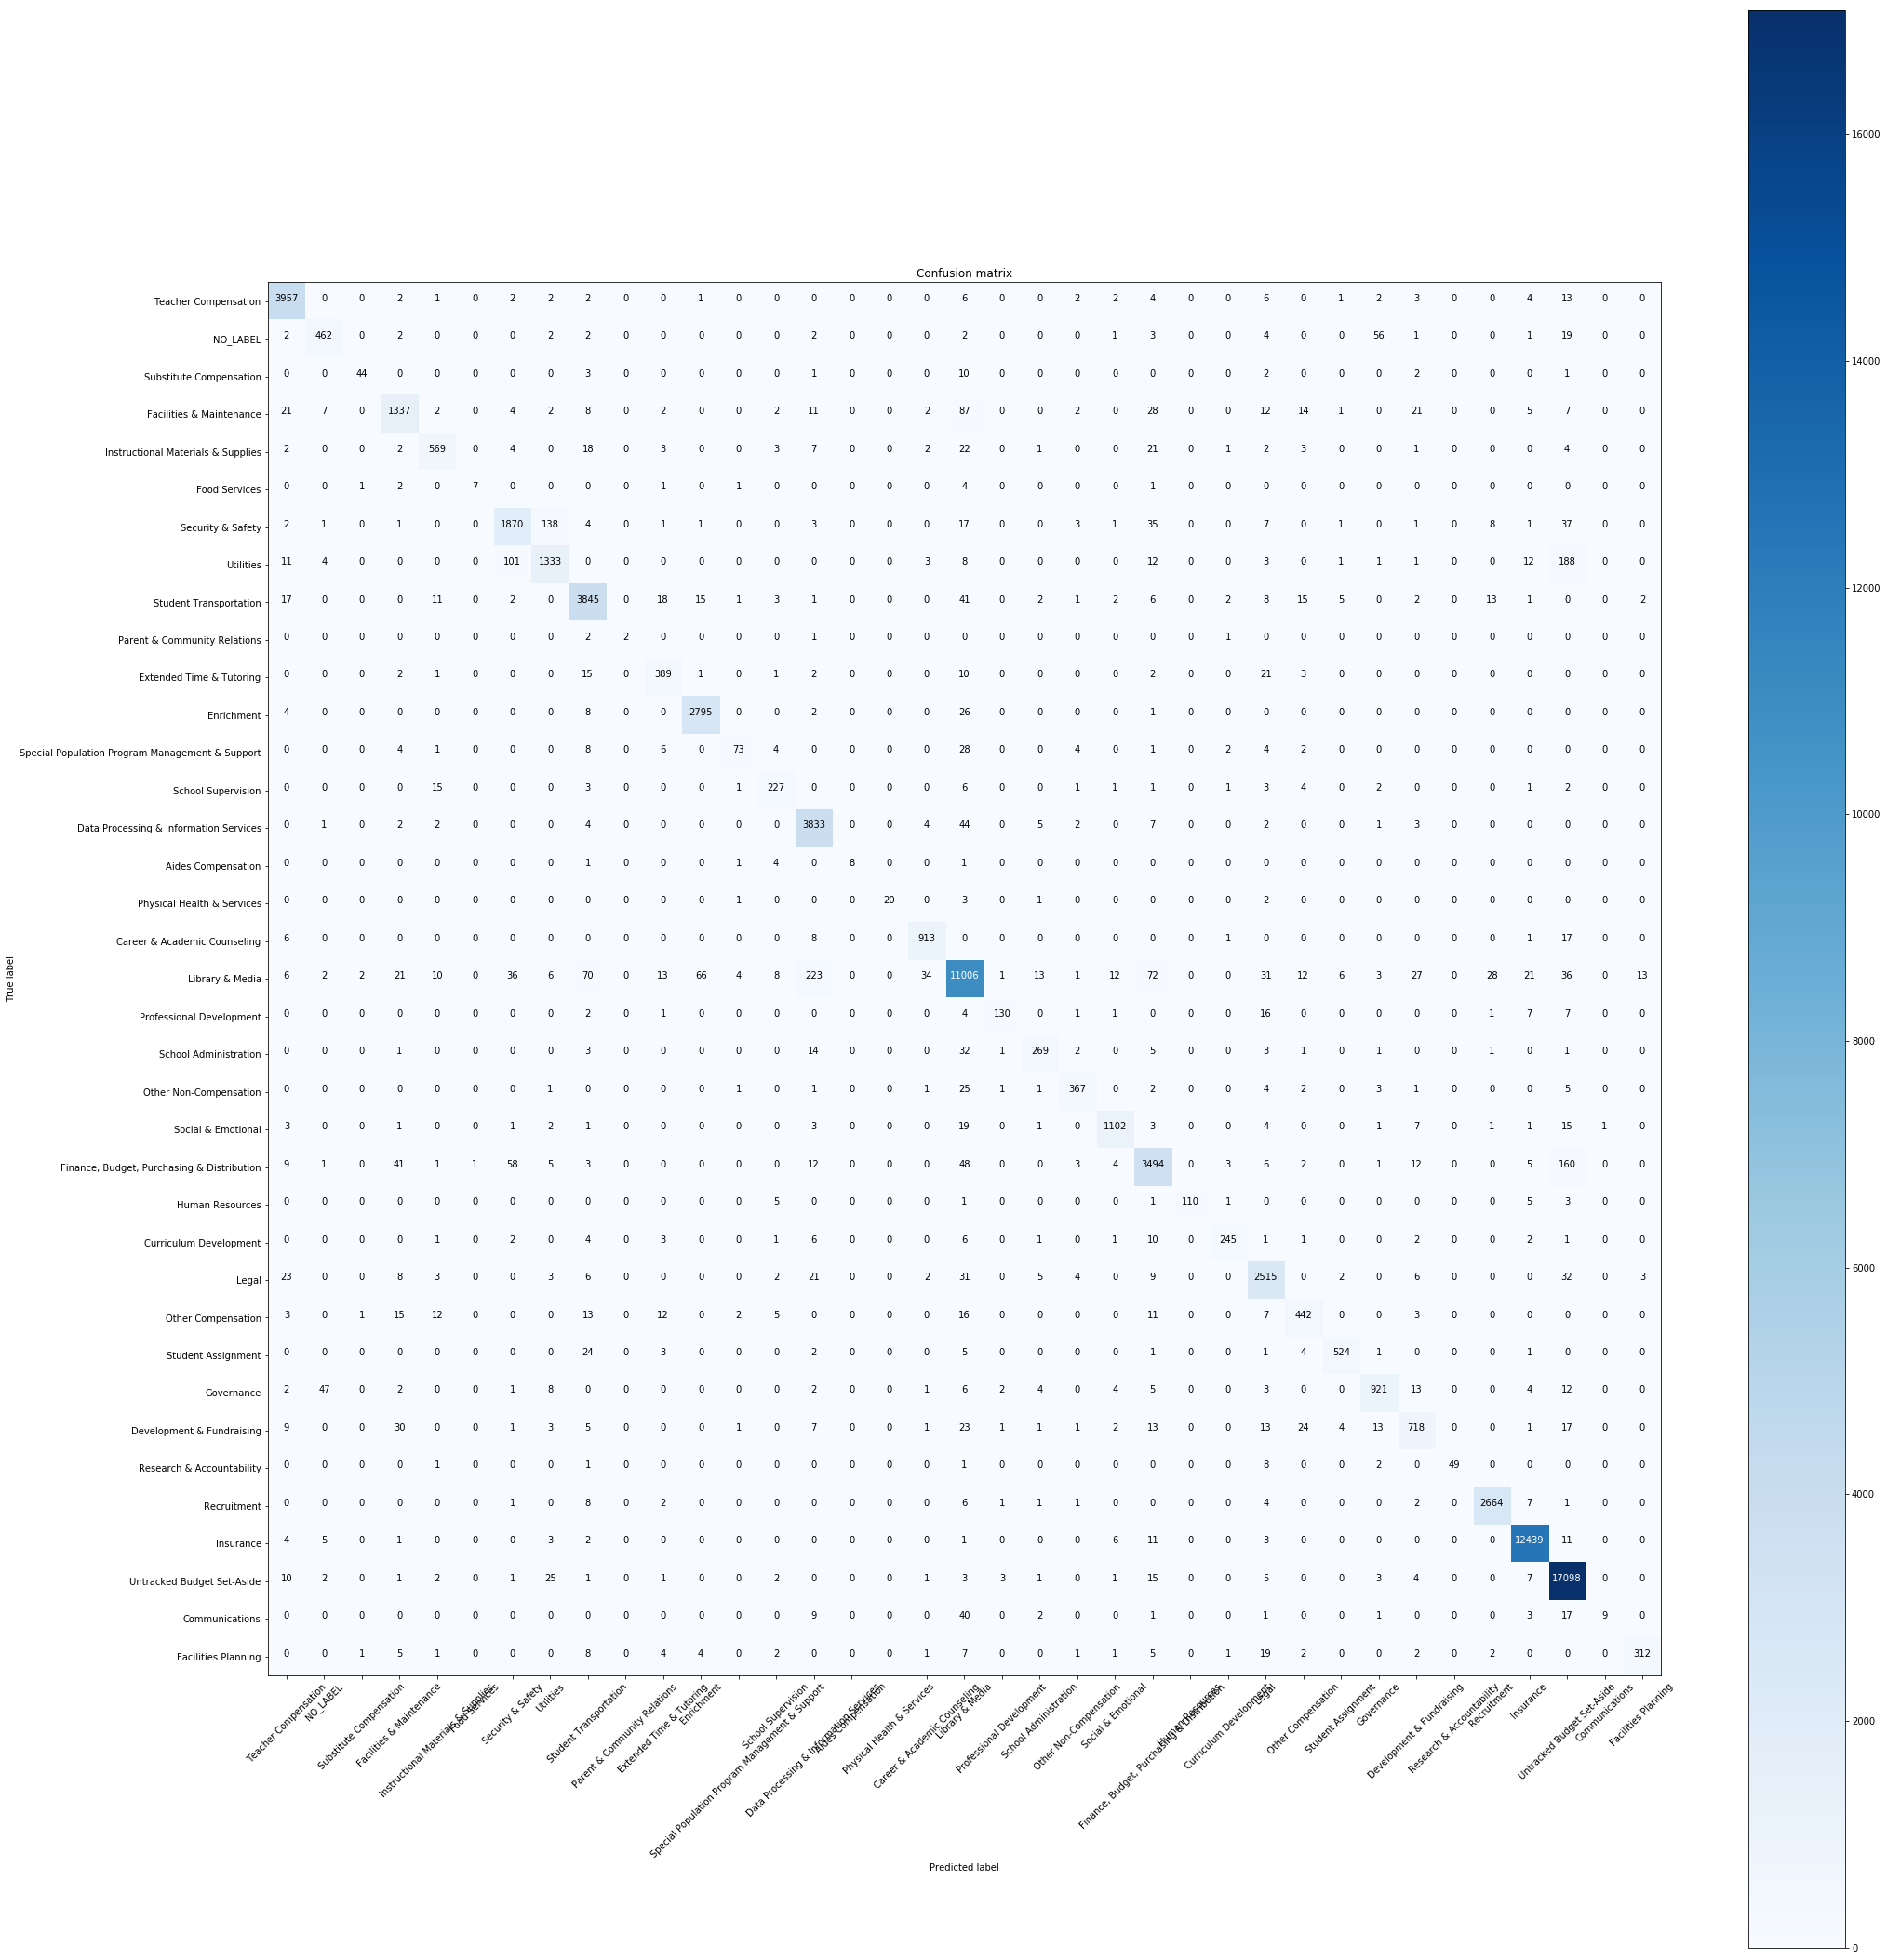

In [51]:
plt.figure(figsize=(30, 30))
plot_cm(the_cm, the_labels['Function'])

Normalized confusion matrix
[[9.86783042e-01 0.00000000e+00 0.00000000e+00 4.98753117e-04
  2.49376559e-04 0.00000000e+00 4.98753117e-04 4.98753117e-04
  4.98753117e-04 0.00000000e+00 0.00000000e+00 2.49376559e-04
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 1.49625935e-03 0.00000000e+00
  0.00000000e+00 4.98753117e-04 4.98753117e-04 9.97506234e-04
  0.00000000e+00 0.00000000e+00 1.49625935e-03 0.00000000e+00
  2.49376559e-04 4.98753117e-04 7.48129676e-04 0.00000000e+00
  0.00000000e+00 9.97506234e-04 3.24189526e-03 0.00000000e+00
  0.00000000e+00]
 [3.57781753e-03 8.26475850e-01 0.00000000e+00 3.57781753e-03
  0.00000000e+00 0.00000000e+00 0.00000000e+00 3.57781753e-03
  3.57781753e-03 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 3.57781753e-03 0.00000000e+00
  0.00000000e+00 0.00000000e+00 3.57781753e-03 0.00000000e+00
  0.00000000e+00 0.00000000e+00 1.78890877e-03 5.36672630e-03
  0.00000000e+00 0.00000

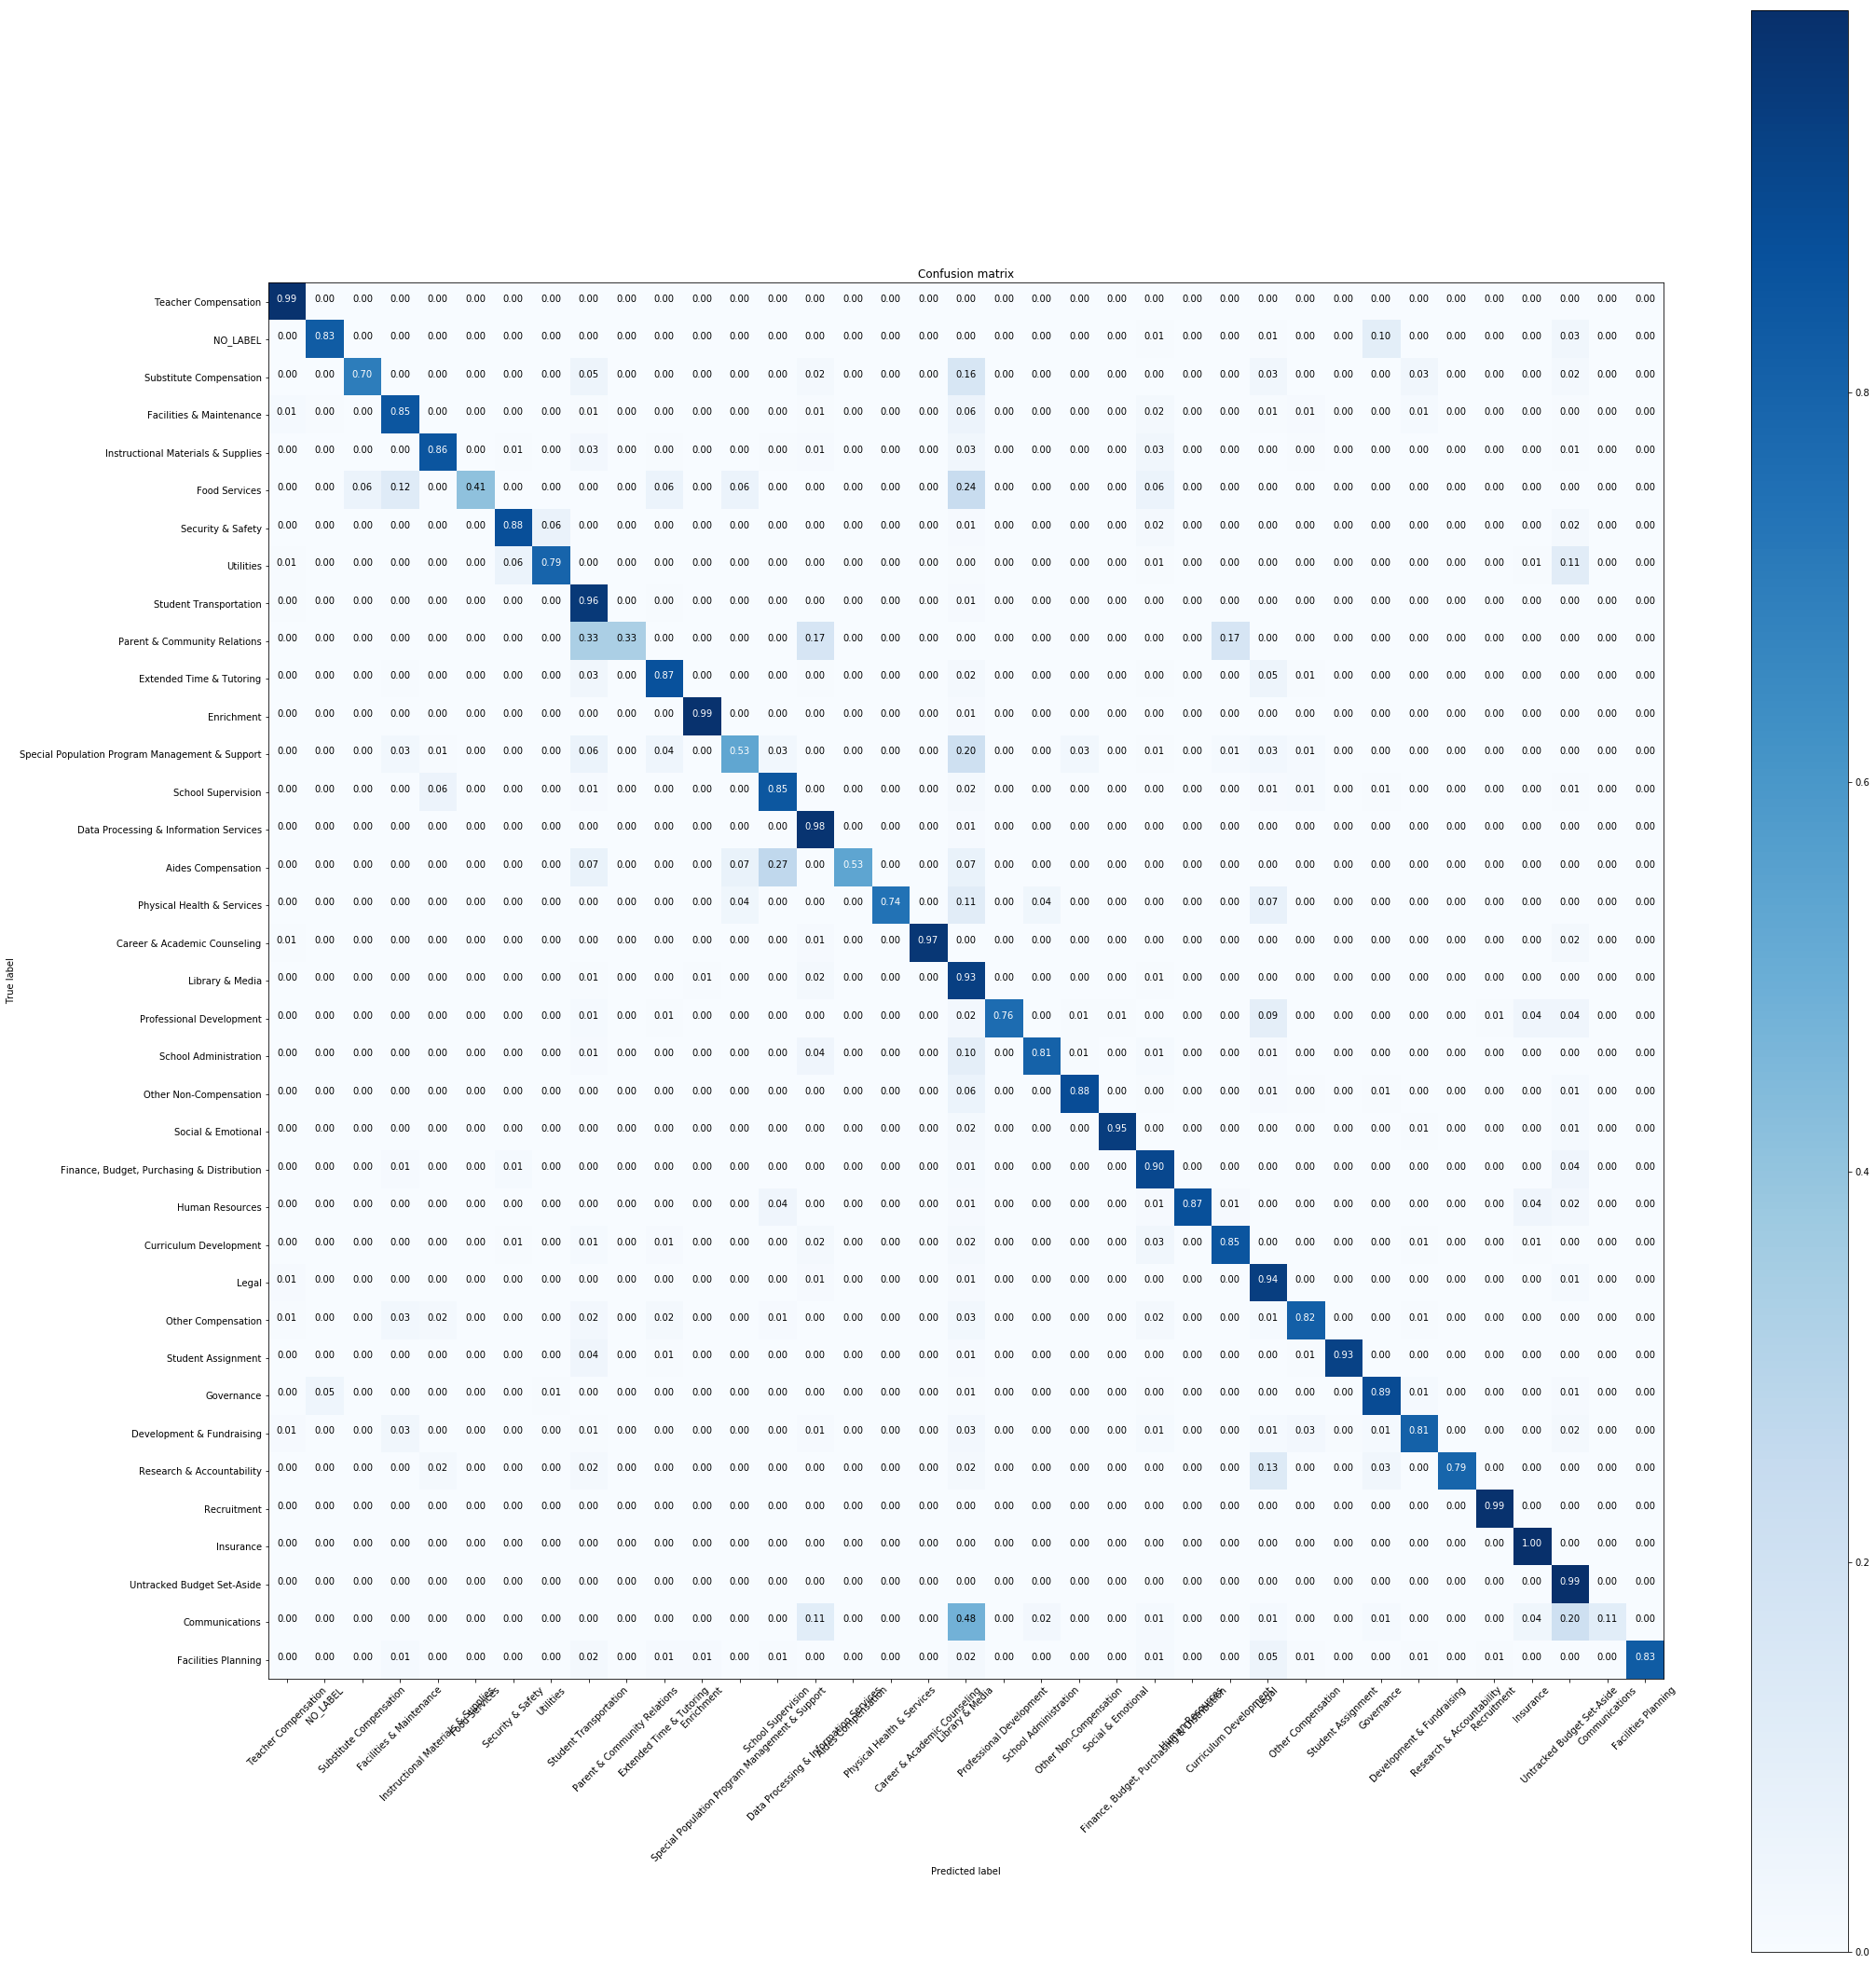

In [52]:
plt.figure(figsize=(30, 30))
plot_cm(the_cm, the_labels['Function'], normalize=True)

***